In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
print(words[:10])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033


In [3]:
chars = sorted(set(''.join(words)))
itos = {i+1:c for i,c in enumerate(chars)}
itos[0] = '.'
stoi = {c:i for i,c in itos.items()}
vocab_size = len(stoi)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 8

def build_dataset(words):
    X, Y = [],[]
    for word in words:
        context = [0] * block_size
        for ch in word+'.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int( 0.8 * len(words))
n2 = int( 0.9 * len(words))

Xtr , Ytr = build_dataset(words[:n1])
Xval , Yval = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self,fan_in,fan_out,bias = True):
        self.weight = torch.randn((fan_in,fan_out)) / fan_in ** 0.5
        self.bias = torch.randn((fan_out,)) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self,dim,eps = 1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters
        self.beta = torch.ones(dim)
        self.gamma = torch.zeros(dim)

        #buffers

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        if self.training:
            xmean = x.mean(0,keepdim = True)
            xvar = x.var(0,keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.beta * xhat + self.gamma
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + (self.momentum * xmean)
                self.running_var = (1 - self.momentum) * self.running_var + (self.momentum * xvar)
        return self.out
    def parameters(self):
        return [self.beta ,self.gamma]
    

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self,num_embedding,embedding_dim):
        self.weight = torch.randn((num_embedding,embedding_dim))
    def __call__(self,IX):
        self.out =  self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Sequential:

    def __init__(self,layers):
        self.layers = layers
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    

In [6]:
torch.manual_seed(42)

In [7]:

# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   Flatten(),
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])
# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
   model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum([p.nelement() for p in parameters])) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 4.6276
  10000/ 200000: 2.2158
  20000/ 200000: 1.5508
  30000/ 200000: 2.3130
  40000/ 200000: 2.1880
  50000/ 200000: 1.8051
  60000/ 200000: 2.2810
  70000/ 200000: 1.9673
  80000/ 200000: 1.6770
  90000/ 200000: 1.8327
 100000/ 200000: 1.9750
 110000/ 200000: 2.1511
 120000/ 200000: 1.7625
 130000/ 200000: 2.1637
 140000/ 200000: 1.9470
 150000/ 200000: 2.0251
 160000/ 200000: 2.0999
 170000/ 200000: 1.8913
 180000/ 200000: 1.8140
 190000/ 200000: 1.6597


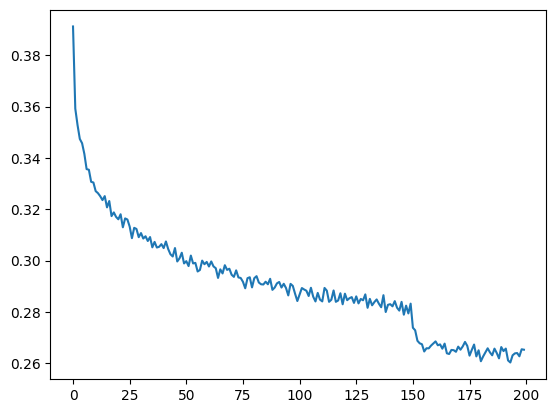

In [9]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [10]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [11]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8079982995986938
val 1.9917888641357422


In [12]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

jeremii.
pearce.
sverita.
nolm.
aidh.
rmiliyah.
emlynn.
gilee.
nyamir.
hanora.
sandhras.
kasele.
jaxoben.
mendy.
maddilynn.
lawsyn.
nikoluwa.
palfham.
favuri.
jessalin.
